# 1 Parameter setting

In [1]:
import os
import ppap4lmp as pp
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


In [2]:
cwd = os.getcwd()
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

path = "/home/yang/kimberly/mass_density_60_60/amide_0.5"

OFMnum = 60          # Number of OFMs ------ [92 for High; 46 for Medium; 22 for Low]

Files in '/home/yang/kimberly/mass_density_60_60/amide_0.5': ['Cal_NumberDensityDistribution_volume.ipynb', 'Analyze']


In [3]:
# path_dumps = path + "/dumps_all"

path_dumps = "/mnt/Kim_3/2.0_c12amide/60pao_60ofm/7.shear_0.5G_rerun/dumps_all"

if not os.path.exists(path + "/Analyze"):
    os.makedirs(path + "/Analyze")
path_Analyze = path + "/Analyze"

# os.chdir(path_dumps)
# print(os.getcwd())

In [4]:
dump_start = 9000000    #20496000
dump_end =   14000000
dump_interval = 2000

FilmThickness = 20 # Å, Can be a little bigger than real film thickness
#OFMnum = ?
gap = 0.1           # The interval of each layer

In [5]:
box_x = 130.813   # Å
box_y = 35.245   # Å

#Area = box_x * box_y   # Å^2, NOTE: It is better to use volume, not area! I have changed area to volume in EXCEL.

Volume = box_x * box_y * gap    # Å^3 在这个新的程序里面，改成了直接除以体积，避免在excel里重新算

print(Volume)

461.0504184999999


In [6]:
# start_dump = 4001
# end_dump = 6502
# 
# dumps = sorted([
  # (int(os.path.basename(path).split(".")[1]), path)
  # for path in glob(path_dumps)
# ])[start_dump:end_dump] 
# 
# print(dumps[:1])
# print(dumps[-1:])
# print(len(dumps))
# 
# atoms_traj = [
  # pp.create(pp.StaDumpAtoms(path, step))
  # for step, path in dumps
# ]   
# 
# 
# for atoms in atoms_traj:
  # atoms.append_updater(pp.FilSet({"type": {17}}))
# 
# pro = pp.ProValueArray(atoms_traj)
# pro.select("zu")
# pp.execute_omp(pro)
# results = pro.get_results()
# zu_array_Fe = results["zu"]
# MaxLowerFe = np.zeros(len(atoms_traj))
# for i in range(len(atoms_traj)):
    # MaxLowerFe[i] = np.max(zu_array_Fe[i])  # Z_max for Fe in lower interface  
# print(MaxLowerFe)



# 2 Program running

In [7]:
# 判断之前是否已经保存过基板的[最大][最小]坐标：若没有，则计算并输出保存；若有，则直接读取
# 因为计算一次要花很长时间

# 1. Find Max lower Fe
if not os.path.isfile(path_Analyze + "/Data_MaxLowerFe_Original" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt"):
  
  os.chdir(path_dumps)
  atoms_traj = [pp.create(
  pp.StaDumpAtoms("atom.{}.dump".format(i), i))
  for i in range(dump_start, dump_end+2000, dump_interval)]

  for atoms in atoms_traj:
    atoms.append_updater(pp.FilSet({"type": {17}}))  # Type 17: Fe's type on lower interface

  pro = pp.ProValueArray(atoms_traj)
  pro.select("zu")
  pp.execute_omp(pro)
  results = pro.get_results()
  zu_array_Fe = results["zu"]

  MaxLowerFe = np.zeros(len(atoms_traj))
  for i in range(len(atoms_traj)):
      MaxLowerFe[i] = np.max(zu_array_Fe[i])  # Z_max for Fe in lower interface  
  print(MaxLowerFe)

  os.chdir(path_Analyze)
  np.savetxt("Data_MaxLowerFe_Original" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt", MaxLowerFe, fmt='%f', delimiter=' ')

else:
  print("Will read MaxLowerFe directly from the previous saved file.")
  



Will read MaxLowerFe directly from the previous saved file.


In [8]:
# Read MaxLowerFe and MinUpperFe from file no matter re-calculated or not.

os.chdir(path_Analyze)
MaxLowerFe = np.loadtxt(
    "Data_MaxLowerFe_Original" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt",
    delimiter = " ",
    skiprows = 0,
)

In [9]:
# Get the smallest and largest x-coordinate of oxygen atoms in upper interface

os.chdir(path_dumps)
atoms_traj = [pp.create(
pp.StaDumpAtoms("atom.{}.dump".format(i), i))
for i in range(dump_start, dump_end+2000, dump_interval)]

for atoms in atoms_traj:
    atoms.append_updater(pp.FilSet({"type": {24}}))  # Type 24: O's type on upper cylinder surface

In [10]:
if not os.path.isfile(path_Analyze + "/Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt"):
    if not os.path.isfile(path_Analyze + "/Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt"):
        c = pp.ProValueArray(atoms_traj)
        c.select("xu")
        pp.execute_omp(c)
        results = c.get_results()
    
        xu_array_O = results["xu"]
        Min_Oxu = np.zeros(len(atoms_traj))
        Max_Oxu = np.zeros(len(atoms_traj))
        for i in range(len(atoms_traj)):
            Min_Oxu[i] = np.min(xu_array_O[i])
            Max_Oxu[i] = np.max(xu_array_O[i])
        print(Min_Oxu)
        print(Max_Oxu)
    
        os.chdir(path_Analyze)
        np.savetxt("Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt", Min_Oxu, fmt='%f', delimiter=' ')
        np.savetxt("Data_Max_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt", Max_Oxu, fmt='%f', delimiter=' ')
else:
  print("Will read Min_Oxu,Max_Oxu directly from the previous saved file.")

Will read Min_Oxu,Max_Oxu directly from the previous saved file.


In [11]:
os.chdir(path_Analyze)
Min_Oxu = np.loadtxt(
    "Data_Min_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt",
    delimiter = " ",
    skiprows = 0,
)
Max_Oxu = np.loadtxt(
    "Data_Max_Oxu" + str(dump_start) + "_" + str(dump_interval) + "_" + str(dump_end) + ".txt",
    delimiter = " ",
    skiprows = 0,
)

In [12]:
#Cylinder下部のMin_Oxu,Max_OxuをWrap
for i in range (len(atoms_traj)):   
    if Min_Oxu[i] < 0:
        while Min_Oxu[i] < 0:
            Min_Oxu[i] +=  box_x
    elif Min_Oxu[i] > box_x:
        while Min_Oxu[i] > box_x:
            Min_Oxu[i] -= box_x

for i in range (len(atoms_traj)):   
    if Max_Oxu[i] < 0:
        while Max_Oxu[i] < 0:
         Max_Oxu[i] +=  box_x
    elif Max_Oxu[i] > box_x:
        while Max_Oxu[i] > box_x:
         Max_Oxu[i] -= box_x

print(Min_Oxu)
print(Max_Oxu)

[24.614 24.829 25.026 ...  0.966  1.266  1.476]
[59.654 59.918 60.187 ... 36.046 36.276 36.516]


## 2.1 Cal mass density profile for PAO atoms

In [13]:
os.chdir(path_dumps)
atoms_traj = [pp.create(
  pp.StaDumpAtoms("atom.{}.dump".format(i), i))
  for i in range(dump_start, dump_end+2000, dump_interval)]

In [14]:
len(atoms_traj)

2501

In [15]:
for atoms in atoms_traj:
    atoms.append_updater(pp.FilSet({"type": {1,2,3}}))  
    # 1: C     2: C     3: H

pro = pp.ProValueArray(atoms_traj)
pro.select("zu","type","xu")

pp.execute_omp(pro)

results = pro.get_results()

zu_array = results["zu"]
type_array = results["type"]
xu_array = results["xu"]

print(type_array)

[[1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 ...
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]]


In [16]:
# total number of atoms selected 

atom_num = 7320            # 1: C     2: C     3: H

In [17]:
for i in range (len(atoms_traj)):   
    for j in range (atom_num):    #7320
        if xu_array[i][j] < 0:
            while xu_array[i][j]<0:
                xu_array[i][j] = xu_array[i][j]+box_x
        elif xu_array[i][j] > box_x:
            while xu_array[i][j]>box_x:
                xu_array[i][j] -= box_x
        xu_array[i][j] = round(xu_array[i][j], 4)
print(xu_array)

[[ 88.729  87.701  86.51  ... 117.959 116.512 117.053]
 [ 89.269  88.405  87.257 ... 117.678 117.919 119.319]
 [ 89.638  89.096  87.695 ... 117.316 118.469 119.006]
 ...
 [ 60.395  59.467  59.196 ... 114.369 112.739 113.769]
 [ 60.739  61.322  61.053 ... 113.629 115.349 114.969]
 [ 60.111  60.684  59.862 ... 116.949 115.579 116.269]]


In [18]:
Mass_C = np.zeros(5000)
Mass_H = np.zeros(5000) 
z = np.zeros(5000) 


for i in range (len(atoms_traj)):
    for j in range (atom_num): 

      layer_C = (zu_array[i][j] - MaxLowerFe[i]) // gap   # 0.3//0.5=0; 0.9//0.5=1.0; 1.1//0.5=2.0
      if Min_Oxu[i] < Max_Oxu[i]:
        if Min_Oxu[i]<=xu_array[i][j]<=Max_Oxu[i]:


          if type_array[i][j] == 1 or type_array[i][j] == 2 :
            Mass_C[int(layer_C)] = Mass_C[int(layer_C)] + 12
          
          if type_array[i][j] == 3 :
            Mass_H[int(layer_C)] = Mass_H[int(layer_C)] + 1
            
      elif Min_Oxu[i] > Max_Oxu[i]:
        if Min_Oxu[i]<=xu_array[i][j] or xu_array[i][j]<=Max_Oxu[i]:


          if type_array[i][j] == 1 or type_array[i][j] == 2 :
            Mass_C[int(layer_C)] = Mass_C[int(layer_C)] + 12
          
          if type_array[i][j] == 3 :
            Mass_H[int(layer_C)] = Mass_H[int(layer_C)] + 1

      
            
Mass_C = Mass_C / len(atoms_traj)  
Density_C = Mass_C / Volume  
Mass_H = Mass_H / len(atoms_traj)  
Density_H = Mass_H / Volume  

Density = (Density_C + Density_H)*(1.661129568)   

print(Density)

for i in range( int(FilmThickness/gap) ):
    z[i+1] = z[i] + gap

[0. 0. 0. ... 0. 0. 0.]


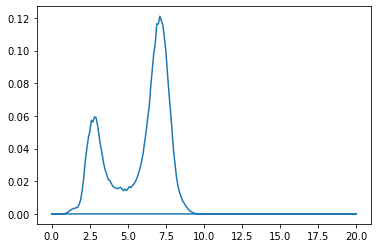

In [19]:
x = z
y1 = Density
plt.plot(x, y1, label = 'PAO')

In [20]:
os.chdir(path_Analyze)

# --------- PAO ---------
wf = open("Data_" + "massd_pao" + ".txt", "w")
wf.write( "Total number of dumps: " + str(len(atoms_traj)) + "\n\n" )
wf.write( "z[A]\tmass_density_pao[g/cm^3]\n" )

#wf.write( "z[Å]\tNDD(C)[/Å^3]\n" )
for i in range( int(FilmThickness/gap) ):
    wf.write(str(round(z[i],2)) + "\t" + str(Density[i]) + "\n")


wf.close()

## 2.1 Cal mass density for amide OFM

In [21]:
os.chdir(path_dumps)
atoms_traj = [pp.create(
  pp.StaDumpAtoms("atom.{}.dump".format(i), i))
  for i in range(dump_start, dump_end+2000, dump_interval)]


for atoms in atoms_traj:
    atoms.append_updater(pp.FilSet({"type": {4,5,6,7,8,9,10,11}}))  
    # all amide atoms

pro = pp.ProValueArray(atoms_traj)
pro.select("zu","type","xu")

pp.execute_omp(pro)

results = pro.get_results()

zu_array = results["zu"]
type_array = results["type"]
xu_array = results["xu"]

print(type_array)
print(xu_array)

[[ 6. 11.  4. ...  7.  8. 10.]
 [ 6. 11.  4. ...  7.  8. 10.]
 [ 6. 11.  4. ...  7.  8. 10.]
 ...
 [ 6. 11.  4. ...  7.  8. 10.]
 [ 6. 11.  4. ...  7.  8. 10.]
 [ 6. 11.  4. ...  7.  8. 10.]]
[[ 93.9117  89.4746  91.5207 ... 100.413  104.105  103.709 ]
 [ 93.7718  89.4843  91.5162 ... 100.787  104.734  104.06  ]
 [ 94.1737  89.5613  91.7628 ... 100.707  104.632  103.927 ]
 ...
 [ 94.1178  89.9046  92.1795 ... 100.92   103.315  103.612 ]
 [ 94.1636  89.8726  92.0807 ... 101.079  102.927  103.788 ]
 [ 94.1101  89.5258  92.1921 ... 101.222  102.858  103.554 ]]


In [22]:
# total number of atoms selected 
print(xu_array)
atom_num = 3960

[[ 93.9117  89.4746  91.5207 ... 100.413  104.105  103.709 ]
 [ 93.7718  89.4843  91.5162 ... 100.787  104.734  104.06  ]
 [ 94.1737  89.5613  91.7628 ... 100.707  104.632  103.927 ]
 ...
 [ 94.1178  89.9046  92.1795 ... 100.92   103.315  103.612 ]
 [ 94.1636  89.8726  92.0807 ... 101.079  102.927  103.788 ]
 [ 94.1101  89.5258  92.1921 ... 101.222  102.858  103.554 ]]


In [23]:
for i in range (len(atoms_traj)):   
    for j in range (atom_num):    #3960
        if xu_array[i][j] < 0:
            while xu_array[i][j]<0:
                xu_array[i][j] = xu_array[i][j]+box_x
        elif xu_array[i][j] > box_x:
            while xu_array[i][j]>box_x:
                xu_array[i][j] -= box_x
        xu_array[i][j] = round(xu_array[i][j], 4)
print(xu_array)

[[ 93.9117  89.4746  91.5207 ... 100.413  104.105  103.709 ]
 [ 93.7718  89.4843  91.5162 ... 100.787  104.734  104.06  ]
 [ 94.1737  89.5613  91.7628 ... 100.707  104.632  103.927 ]
 ...
 [ 94.1178  89.9046  92.1795 ... 100.92   103.315  103.612 ]
 [ 94.1636  89.8726  92.0807 ... 101.079  102.927  103.788 ]
 [ 94.1101  89.5258  92.1921 ... 101.222  102.858  103.554 ]]


In [24]:
Mass_C = np.zeros(5000)
Mass_H = np.zeros(5000) 
Mass_O = np.zeros(5000)
Mass_N = np.zeros(5000)
z = np.zeros(5000) 


for i in range (len(atoms_traj)):
    for j in range (atom_num): 

      layer_C = (zu_array[i][j] - MaxLowerFe[i]) // gap   # 0.3//0.5=0; 0.9//0.5=1.0; 1.1//0.5=2.0

      if Min_Oxu[i] < Max_Oxu[i]:
        if Min_Oxu[i]<=xu_array[i][j]<=Max_Oxu[i]:

            if type_array[i][j] == 4 or type_array[i][j] == 5 :
                Mass_C[int(layer_C)] = Mass_C[int(layer_C)] + 12
            
            if type_array[i][j] == 7 or type_array[i][j] == 9:
                Mass_H[int(layer_C)] = Mass_H[int(layer_C)] + 1

            if type_array[i][j] == 6 or type_array[i][j] == 11:
                Mass_O[int(layer_C)] = Mass_O[int(layer_C)] + 16
            
            if type_array[i][j] == 8 or type_array[i][j] == 10:
                Mass_N[int(layer_C)] = Mass_N[int(layer_C)] + 14



      elif Min_Oxu[i] > Max_Oxu[i]:
        if Min_Oxu[i]<=xu_array[i][j] or xu_array[i][j]<=Max_Oxu[i]:

            if type_array[i][j] == 4 or type_array[i][j] == 5 :
                Mass_C[int(layer_C)] = Mass_C[int(layer_C)] + 12
            
            if type_array[i][j] == 7 or type_array[i][j] == 9:
                Mass_H[int(layer_C)] = Mass_H[int(layer_C)] + 1

            if type_array[i][j] == 6 or type_array[i][j] == 11:
                Mass_O[int(layer_C)] = Mass_O[int(layer_C)] + 16
            
            if type_array[i][j] == 8 or type_array[i][j] == 10:
                Mass_N[int(layer_C)] = Mass_N[int(layer_C)] + 14

      
            
Mass_C = Mass_C / len(atoms_traj)  
Density_C = Mass_C / Volume  
Mass_H = Mass_H / len(atoms_traj)  
Density_H = Mass_H / Volume  
Mass_O = Mass_O / len(atoms_traj)  
Density_O = Mass_O / Volume  
Mass_N = Mass_N / len(atoms_traj)  
Density_N = Mass_N / Volume  

Density_OFM = (Density_C + Density_H + Density_O + Density_N)*(1.661129568)   

print(Density_OFM)

for i in range( int(FilmThickness/gap) ):
    z[i+1] = z[i] + gap

[0.00000000e+00 5.76237328e-06 3.74554263e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


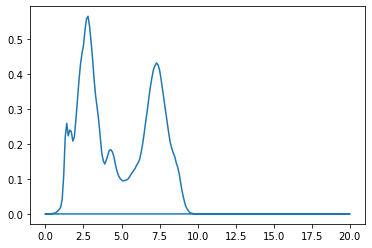

In [25]:
x = z
y2 = Density_OFM
plt.plot(x, y2, label = 'OFM')


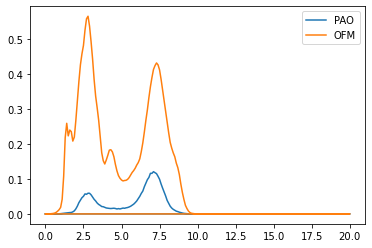

In [26]:
x = z
y1 = Density
plt.plot(x, y1, label = 'PAO')
y2 = Density_OFM
plt.plot(x, y2, label = 'OFM')
plt.legend()
plt.show()

In [28]:
os.chdir(path_Analyze)

# --------- OFM ---------
wf = open("Data_" + "massd_amide_OFM" + ".txt", "w")
wf.write( "Total number of dumps: " + str(len(atoms_traj)) + "\n\n" )
wf.write( "z[A]\tmass_density_amide[g/cm^3]\n" )

#wf.write( "z[Å]\tNDD(C)[/Å^3]\n" )
for i in range( int(FilmThickness/gap) ):
    wf.write(str(round(z[i],2)) + "\t" + str(Density_OFM[i]) + "\n")
